In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def acquire():
    raw_df = pd.read_csv("flavors_of_cacao.csv") 
    return raw_df

def renaming_col(raw_df):
    old_colnames = raw_df.columns
    new_colnames = ['company','origin','ref','review_date','cocoa_percentage',
                'company_location','rating','bean_type','country']
    raw_df_newcol = raw_df.rename(columns=dict(zip(old_colnames, new_colnames)))
    return raw_df_newcol

def droping_col(raw_df_newcol):
    raw_df_newcol_dropcol = raw_df_newcol.drop(['company','company_location','ref', 'review_date'], axis=1)
    return raw_df_newcol_dropcol

def droping_null(raw_df_newcol_dropcol):
    raw_df_newcol_dropcol_nonull = raw_df_newcol_dropcol.dropna()
    return raw_df_newcol_dropcol_nonull

def binning_data(raw_df_newcol_dropcol_nonull):
    rating_level=['Unpleasant','Disappointing','Satisfactory','Premium','Elite']
    bins = pd.cut(raw_df_newcol_dropcol_nonull['rating'], 5, labels = rating_level)
    raw_df_newcol_dropcol_nonull['quality_bin'] = bins
    binned_data = raw_df_newcol_dropcol_nonull
    return binned_data

def country_drop(binned_data):
    country_count = binned_data.country.value_counts()
    countries_to_drop = list(country_count[(country_count < 10) | (country_count == 73)].index)
    return countries_to_drop

def api():
    response = requests.get('https://restcountries.eu/rest/v2/all?fields=name;subregion')
    results = response.json()
    return results

def api_data(results):
    new_data = pd.DataFrame(results)
    new_data = new_data.reindex_axis(['subregion', 'name'], axis=1)
    new_data['name']= new_data['name'].str.replace('Venezuela (Bolivarian Republic of)','Venezuela', regex=False)
    return new_data# All good

def unifying_api_data(new_data):
    for country_dataframe in binned_data['country']:
        for country_api in new_data['name']:
           if country_api == country_dataframe:
                binned_data['subregion'] = new_data['subregion']
    return binned_data

def change_col_with_api(binned_data):
    raw_df_newcol_nonull_api = binned_data[['subregion', 'country', 'origin', 'bean_type',
                                                   'cocoa_percentage', 'rating', 'quality_bin']]
    return raw_df_newcol_nonull_api


def mean_subregion(raw_df_newcol_nonull_api):
    regions_mean = raw_df_newcol_nonull_api.groupby('subregion')['rating'].mean()
    regions_mean = regions_mean.sort_values(ascending=False)
    results = regions_mean
    return results

def visualize(results):
    fig, ax = plt.subplots(figsize=(9,8))
    barchart = sns.barplot(data=results, x='Make', y='Combined MPG')
    plt.title(title + "\n", fontsize=20)
    return barchart

def save_viz(barchart):
    fig = barchart.get_figure()
    fig.savefig(title + '.png')

    

In [13]:
if __name__ == '__main__':
    raw_df = acquire()
    raw_df_newcol = renaming_col(raw_df)
    raw_df_newcol_dropcol = droping_col(raw_df_newcol)
    raw_df_newcol_dropcol_nonull = droping_null(raw_df_newcol_dropcol)
    binned_data = binning_data(raw_df_newcol_dropcol_nonull)
    countries_to_drop = country_drop(binned_data)
    results = api()
    new_data = api_data(results)
    raw_df_newcol_dropcol_nonull = unifying_api_data(new_data)
    raw_df_newcol_nonull_api = change_col_with_api(binned_data)
    results = mean_subregion(raw_df_newcol_nonull_api)
    barchart = visualize(results)
    save_viz(barchart)
print(regions_mean)
    
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


subregion
Central Asia                 3.800000
Central America              3.593750
Melanesia                    3.550000
South-Eastern Asia           3.500000
Western Asia                 3.500000
Micronesia                   3.464286
Southern Asia                3.416667
Northern Europe              3.312500
Southern Europe              3.308824
Northern America             3.291667
Northern Africa              3.285714
Western Africa               3.264706
                             3.250000
Middle Africa                3.250000
Western Europe               3.222222
Caribbean                    3.214286
Eastern Europe               3.204545
South America                3.183333
Polynesia                    3.150000
Eastern Africa               3.087500
Australia and New Zealand    3.050000
Eastern Asia                 3.031250
Southern Africa              2.916667
Name: rating, dtype: float64


In [23]:
region = new_data.loc[new_data['name'] == 'Venezuela']
print(region)
region=list(region['subregion'])
print(region)
region=region[0]
print(region)

         subregion       name
243  South America  Venezuela
['South America']
South America


In [27]:
df = raw_df_newcol_nonull_api[raw_df_newcol_nonull_api['country'].isin(new_data['name'])]
df.head()

,subregion,country,origin,bean_type,cocoa_percentage,rating,quality_bin
1,Northern Europe,Togo,Kpime,,70%,2.75,Satisfactory
2,Southern Europe,Togo,Atsane,,70%,3.00,Satisfactory
3,Northern Africa,Togo,Akata,,70%,3.50,Premium
4,Polynesia,Peru,Quilla,,70%,3.50,Premium
5,Southern Europe,Venezuela,Carenero,Criollo,70%,2.75,Satisfactory


In [24]:
def func(country):
    region = new_data.loc[new_data['name'] == country]
    subregion=list(region['subregion'])[0]
    return subregion


In [25]:
func('Congo')

'Middle Africa'

In [28]:
df['subregion']=df['country'].apply(func)
df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,subregion,country,origin,bean_type,cocoa_percentage,rating,quality_bin
1,Western Africa,Togo,Kpime,,70%,2.75,Satisfactory
2,Western Africa,Togo,Atsane,,70%,3.00,Satisfactory
3,Western Africa,Togo,Akata,,70%,3.50,Premium
4,South America,Peru,Quilla,,70%,3.50,Premium
5,South America,Venezuela,Carenero,Criollo,70%,2.75,Satisfactory
6,Caribbean,Cuba,Cuba,,70%,3.50,Premium
7,South America,Venezuela,Sur del Lago,Criollo,70%,3.50,Premium
8,South America,Venezuela,Puerto Cabello,Criollo,70%,3.75,Premium
9,South America,Peru,Pablino,,70%,4.00,Premium
10,Central America,Panama,Panama,,70%,2.75,Satisfactory


In [29]:
regions_mean = df.groupby('subregion')['rating'].mean()
#regions_mean = df.groupby('subregion').agg({'rating':'mean'})
regions_mean = regions_mean.sort_values(ascending=False)
regions_mean

subregion
Middle Africa                3.312500
Melanesia                    3.274590
Australia and New Zealand    3.250000
Eastern Africa               3.241830
Central America              3.194323
South America                3.189270
Caribbean                    3.181707
South-Eastern Asia           3.156250
Polynesia                    3.125000
Western Africa               3.093750
Southern Asia                3.041667
Name: rating, dtype: float64

In [ ]:
regions_mean.plot.bar()

ValueError: Could not interpret input 'Venezuela'

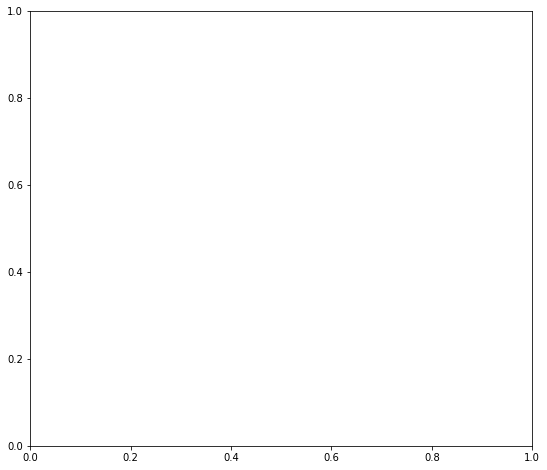

In [30]:
fig, ax = plt.subplots(figsize=(9,8))
barchart = sns.barplot(data=results, x='Venezuela', y='rating')
plt.title(title + "\n", fontsize=20)